#Import Dependencies

In [1]:
import sys
sys.path.append('C:/Users/57lzhang.US04WW4008/PycharmProjects/AF')

In [2]:
from util import util, model_util
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import numpy as np
import sklearn
from sklearn import metrics
print(tf.__version__)

2.3.1


#Load Data

In [3]:
# load training data
train_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/training2017/"
raw_signals, raw_labels = util.data_mining(train_data_file_path)
signals, labels = util.generate_seg_data(raw_signals, raw_labels, seg_len=9000)
signals, labels = util.preprocessing(signals, labels, timedistributed=True)
train_signals, train_labels, val_signals, val_labels = util.split_shuffle_dataset(signals, labels, 0.9)
print('train_signal shape:', train_signals.shape)
print('train_label shape:', train_labels.shape)
print("\nIn training data:") 
util.count_labels(train_labels)
print("\nIn validation data:")
util.count_labels(val_labels)

train_signal shape: (7425, 3, 1250, 1)
train_label shape: (7425, 1)

In training data:
There are 4430 NSR labels
There are 653 AF labels
There are 2342 Other Arrhythmia labels

In validation data:
There are 502 NSR labels
There are 62 AF labels
There are 261 Other Arrhythmia labels


(502, 62, 261)

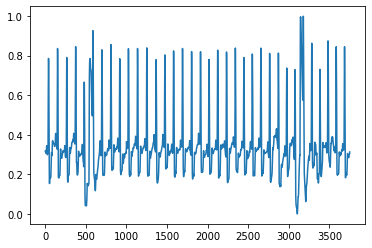

In [4]:
import matplotlib.pyplot as plt
plt.plot(train_signals[2].reshape([3750,1]))

In [5]:
# load testing data
test_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/validation/"
test_raw_signals, test_raw_labels = util.data_mining(test_data_file_path)
test_signals, test_labels = util.generate_seg_data(test_raw_signals, test_raw_labels, seg_len=9000)
test_signals, test_labels = util.preprocessing(test_signals, test_labels, timedistributed=True)
print('test_signal shape:', test_signals.shape)
print('test_label shape:', test_labels.shape)
print("\nIn test data:") 
util.count_labels(test_labels)

test_signal shape: (276, 3, 1250, 1)
test_label shape: (276, 1)

In test data:
There are 150 NSR labels
There are 47 AF labels
There are 79 Other Arrhythmia labels


(150, 47, 79)

#TF Pipeline

In [6]:
# tensorflow pipeline
## extraction
train_dataset = tf.data.Dataset.from_tensor_slices((train_signals, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_signals, val_labels))
## loading
batch_size = 32
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(2048).repeat().batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.repeat().batch(batch_size, drop_remainder=True)

#Model

In [7]:
#cnn + lstm model
model = model_util.cnn_lstm((3,1250,1), classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 1250, 1)]      0         
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 1216)           9776      
_________________________________________________________________
bidirectional (Bidirectional (None, 3, 64)             319744    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 339,987
Trainable params: 339,715
Non-trainable params: 272
_________________________________________________________________


In [9]:
model = model_util.resnet18_lstm(3, 32, 16, 1250, classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

#Callbacks

In [9]:
# callbacks
log_dir = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\logs\fit\\" + \
          datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet"

## confusion matrix callback
def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the test_images.
    
    test_pred_raw = model.predict(val_signals)

    test_pred = np.argmax(test_pred_raw, axis=1)
    test_labels = val_labels.reshape([len(val_labels)])
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)

    figure = model_util.plot_confusion_matrix(cm, class_names=class_names, normalize=True)
    cm_image = model_util.plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

class_names = ['NO Afib','Afib','Others']
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

## tensorboard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

## checkpoint callback
filepath = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\resnet-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')

## learning rate decay callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(model_util.decay)

callbacks_list = [tensorboard_callback, cm_callback, checkpoint, lr_schedule]

#Model Training

In [ ]:
#model training
CLASS_WEIGHTS = util.class_weights(train_labels)

model.fit(train_dataset,
          epochs=200,
          steps_per_epoch=len(list(train_signals))//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(list(val_signals))//batch_size,
          callbacks=callbacks_list,
          class_weight=CLASS_WEIGHTS)

#Training with Autoencoder

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Add, Activation, \
    MaxPooling1D, Dropout, Flatten, TimeDistributed, Bidirectional, Dense, LSTM, ZeroPadding1D, \
    AveragePooling1D, Conv1DTranspose, GlobalMaxPooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector, \
    Lambda, Average

In [ ]:
import os
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models")
ecg_encoder = tf.keras.models.load_model('ECG_Encoder.h5')
conv_encoder_clone = tf.keras.models.clone_model(ecg_encoder)

In [ ]:
def encoder_lstm(input_shape=(3,1250,1), classes=3):
  X_input = Input(shape=input_shape)
  X = TimeDistributed(conv_encoder_clone)(X_input)
  X = TimeDistributed(Flatten())(X)
  X = Bidirectional(LSTM(32, return_sequences=True))(X)
  X = Bidirectional(LSTM(16))(X)
  X = Dense(classes, activation='softmax')(X)

  model = Model(inputs=[X_input], outputs=X)

  return model

In [ ]:
model = encoder_lstm(input_shape=(3,1250,1), classes=3)

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3, 1250, 1)]      0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 3, 1250, 16)       53328     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 3, 20000)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 3, 64)             5128448   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 32)                10368     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 5,192,243
Trainable params: 5,138,915
Non-trainable params: 53,328
_______________________________________

In [ ]:
conv_encoder_clone.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
CLASS_WEIGHTS = util.class_weights(train_labels)

model.fit(train_dataset,
          epochs=200,
          steps_per_epoch=len(list(train_signals))//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(list(val_signals))//batch_size,
          callbacks=callbacks_list,
          class_weight=CLASS_WEIGHTS)